# Deep Hedging AI
### Vanilla Deep Hedging engine reference implementation with dynamic training update.

This is the main example notebook. It shows learning to hedge a vanilla call option (ATM by default), first in a Black & Scholes world with statistical drift, and secondly in a world where a second option can be traded.
The examples are not intended to be overly realistic.

In the Black & Scholes case we see that the hedge learned is _not_ the risk-neutral hedge. The notebook <tt>trainer-bs_nodrift.ipynb</tt> demonstrates that if the statistical drift is zero, and step size is sufficiently small (daily), then the Deep Hedging hedge approximates the risk-neutral hedge.

### Hans Buehler, June 30 2022


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello ... 

2023-01-21 08:52:14.237954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 08:52:14.376291: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


2023-01-21 08:52:15.963723: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-21 08:52:15.963764: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-12-144.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist


## Deep Hedging in a Black \& Scholes World

2023-01-21 08:52:16.721235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Gym with 943 trainable weights compiled and initialized. Took 2s
Network feature information:
 Features used by the agent:        delta, price and time_left
 Features available to the agent:   action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by the utility:      -
 Features available to the utility: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/c1fa105fc24d8baa563da08ea084ce76.pck'
Cache successfully loaded. Current epoch: 799
Nothing to do: cached model loaded from /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/c1fa105fc24d8baa563da08ea084ce76.pck was trained for 800 epochs; you have asked to train for 800 epochs. Raise number of epochs or turn off caching to re-start training.

Plotting results for the trained model.

Training monitor initialized. Took 0s
                                                

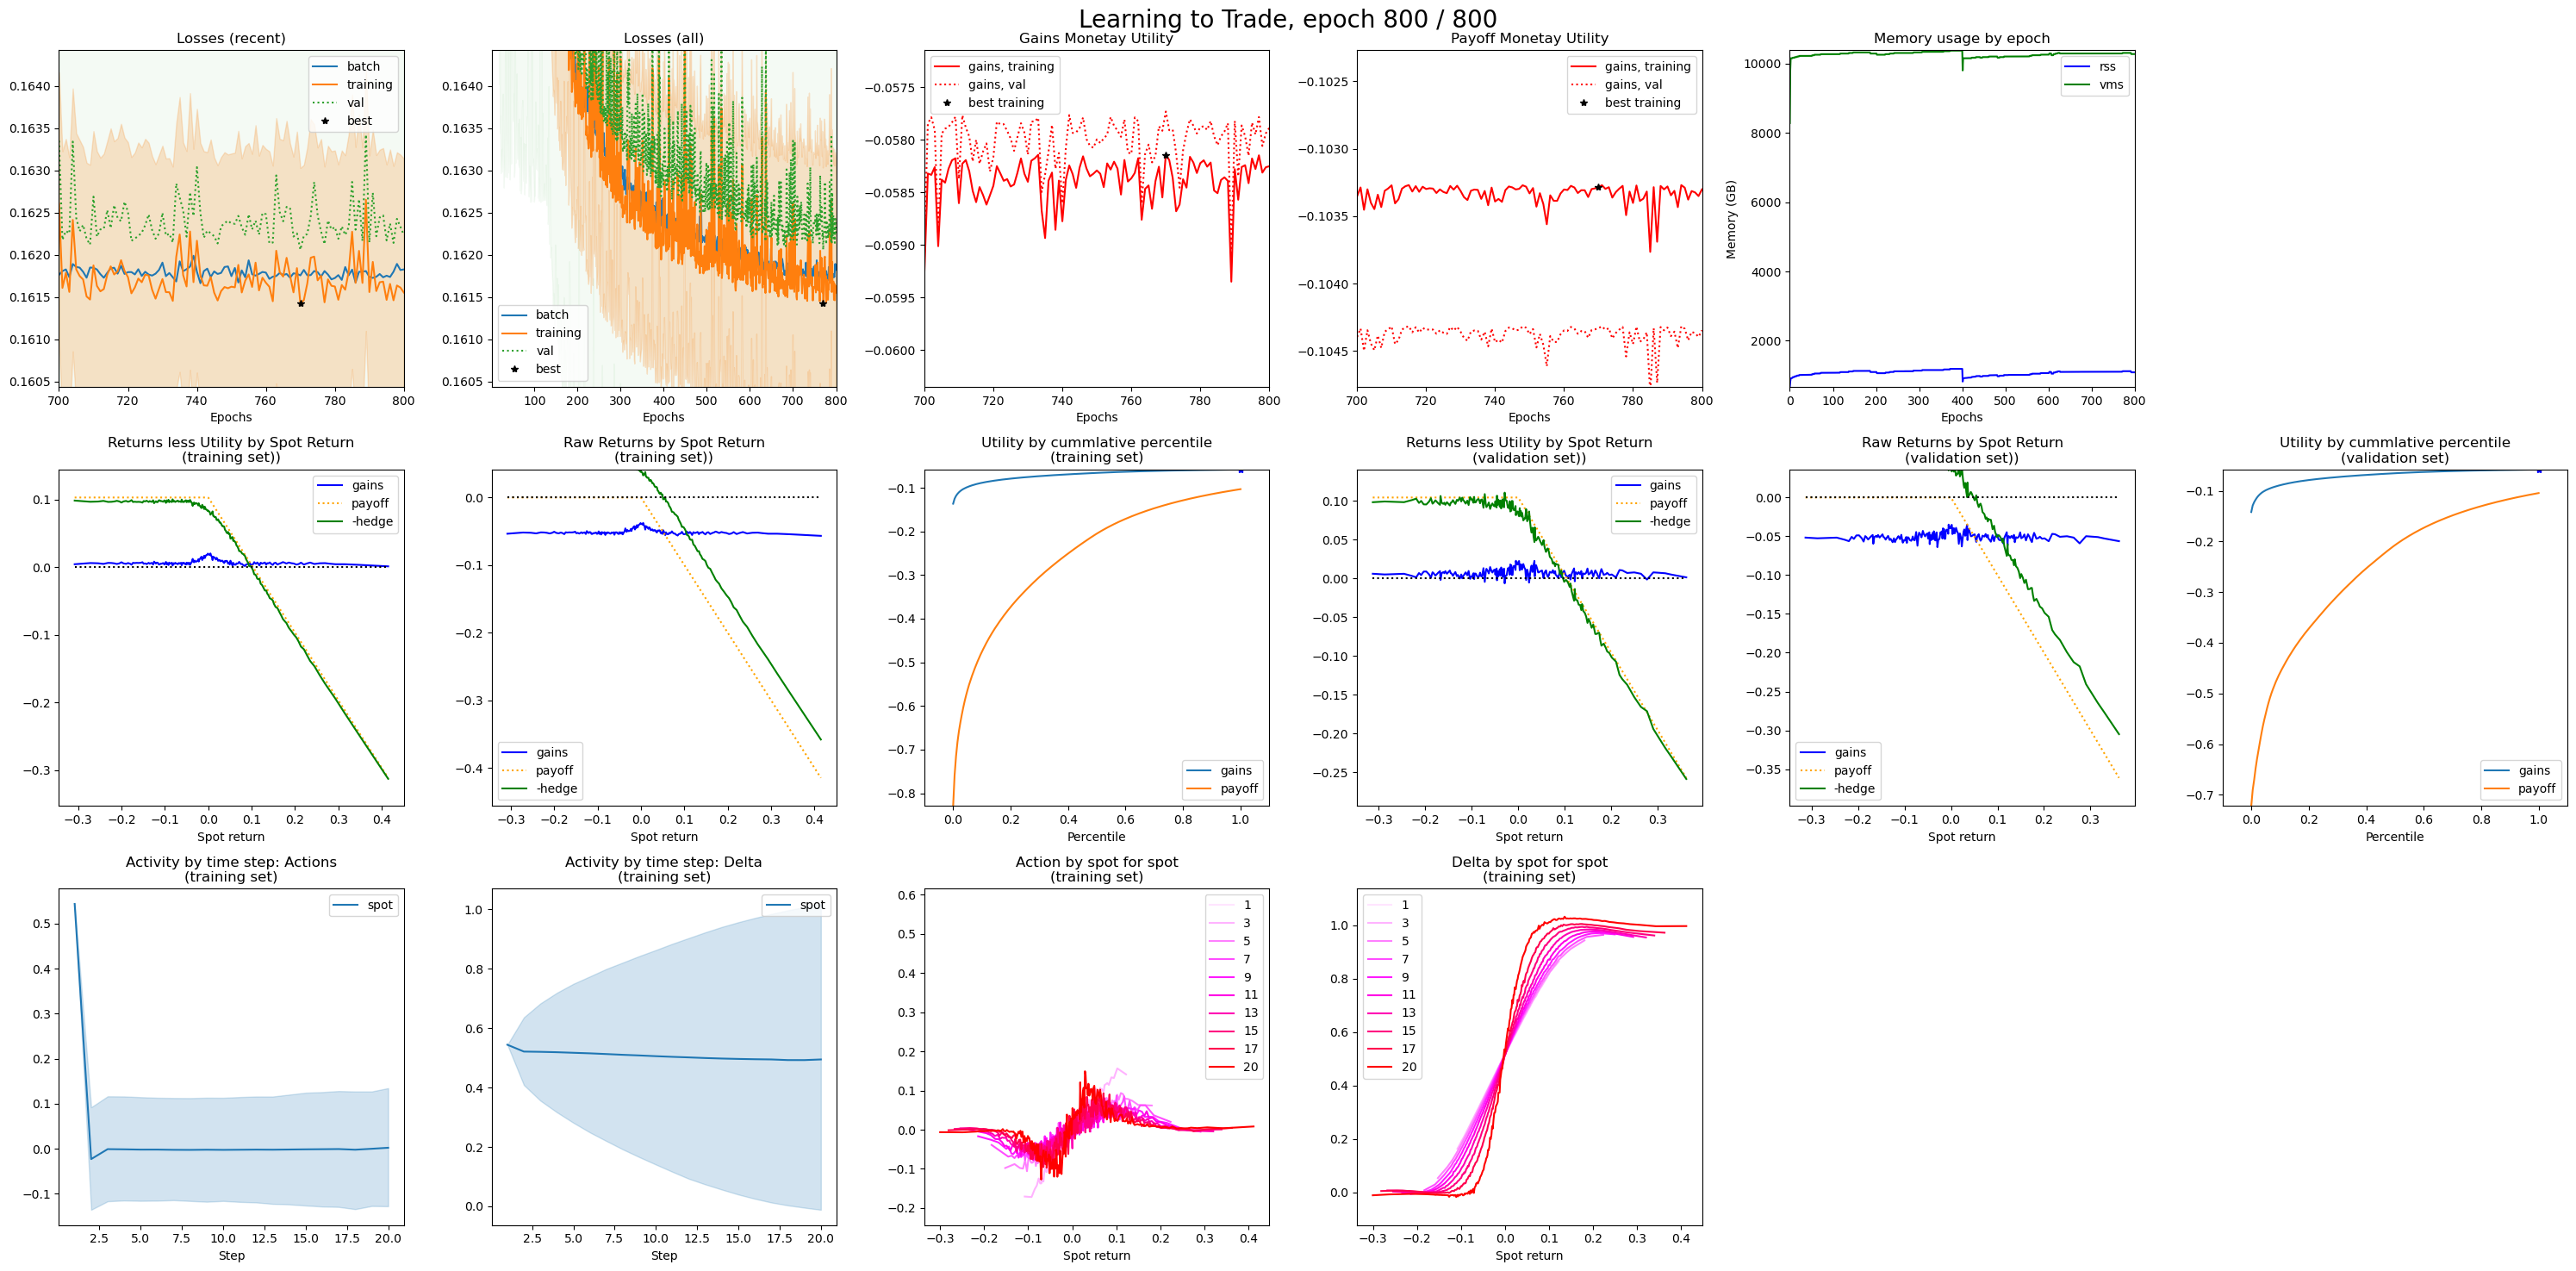

Training 800/800 epochs; 943 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 1.50352 (0.0231862), training 0.161553 (0.00158613), best 0.161427 (0.0231862), batch 0.161827, val 0.162232 (0.00490181). Best epoch 769; last cached 799. | memory used: rss 1089.7M, vms 10275.5M | time elapsed 2:04:03; time per epoch 9s; estimated time remaining 2:04:03                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 769
 State of training until epoch 799 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/c1fa105fc24d8baa563da08ea084ce76.pck

Training terminated. Total time taken 5s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.network['activation'] = softplus # Network activation function; default: relu
config.gym.agent.network['depth'] = 3 # Network depth; default: 3
config

In [2]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
#config.trainer.train.optimizer.learning_rate = 0.001
#config.trainer.train.optimizer.clipvalue = 1.
#config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

#### Comparison to Black & Scholes

See also notebooks/blackscholes for other notebooks. Note that we use medium risk aversion, hence the hedge is not expected to match the risk-neutral hedge. See the sub directory <tt>blackscholes</tt> for experiments approximating the black & scholes solution

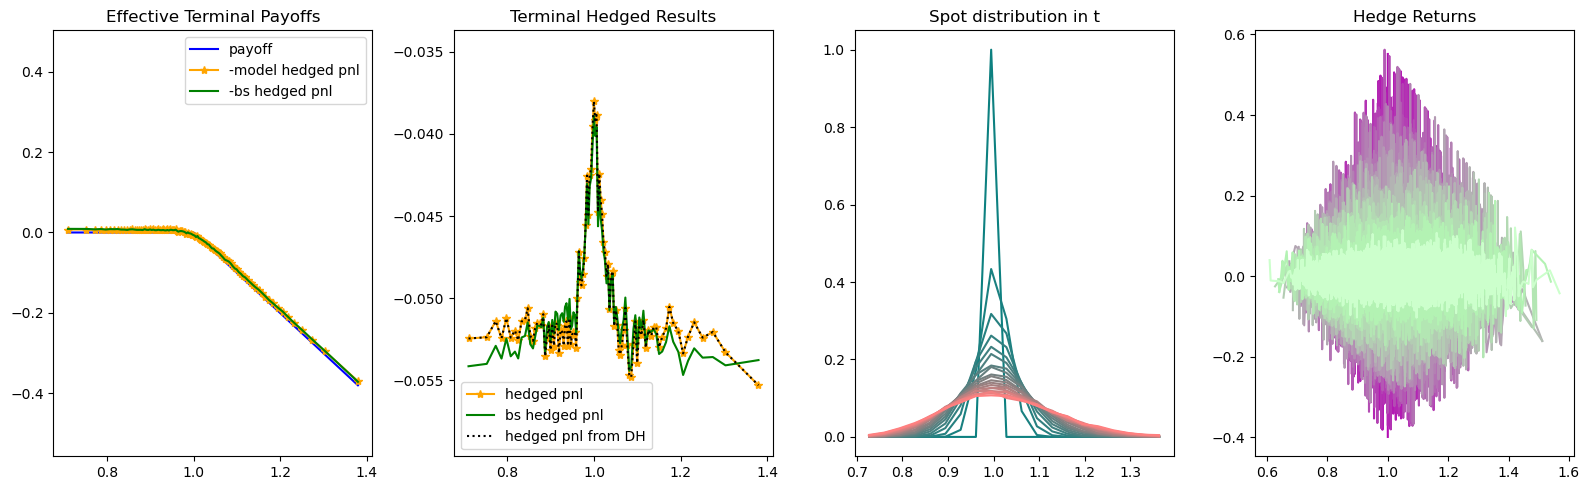

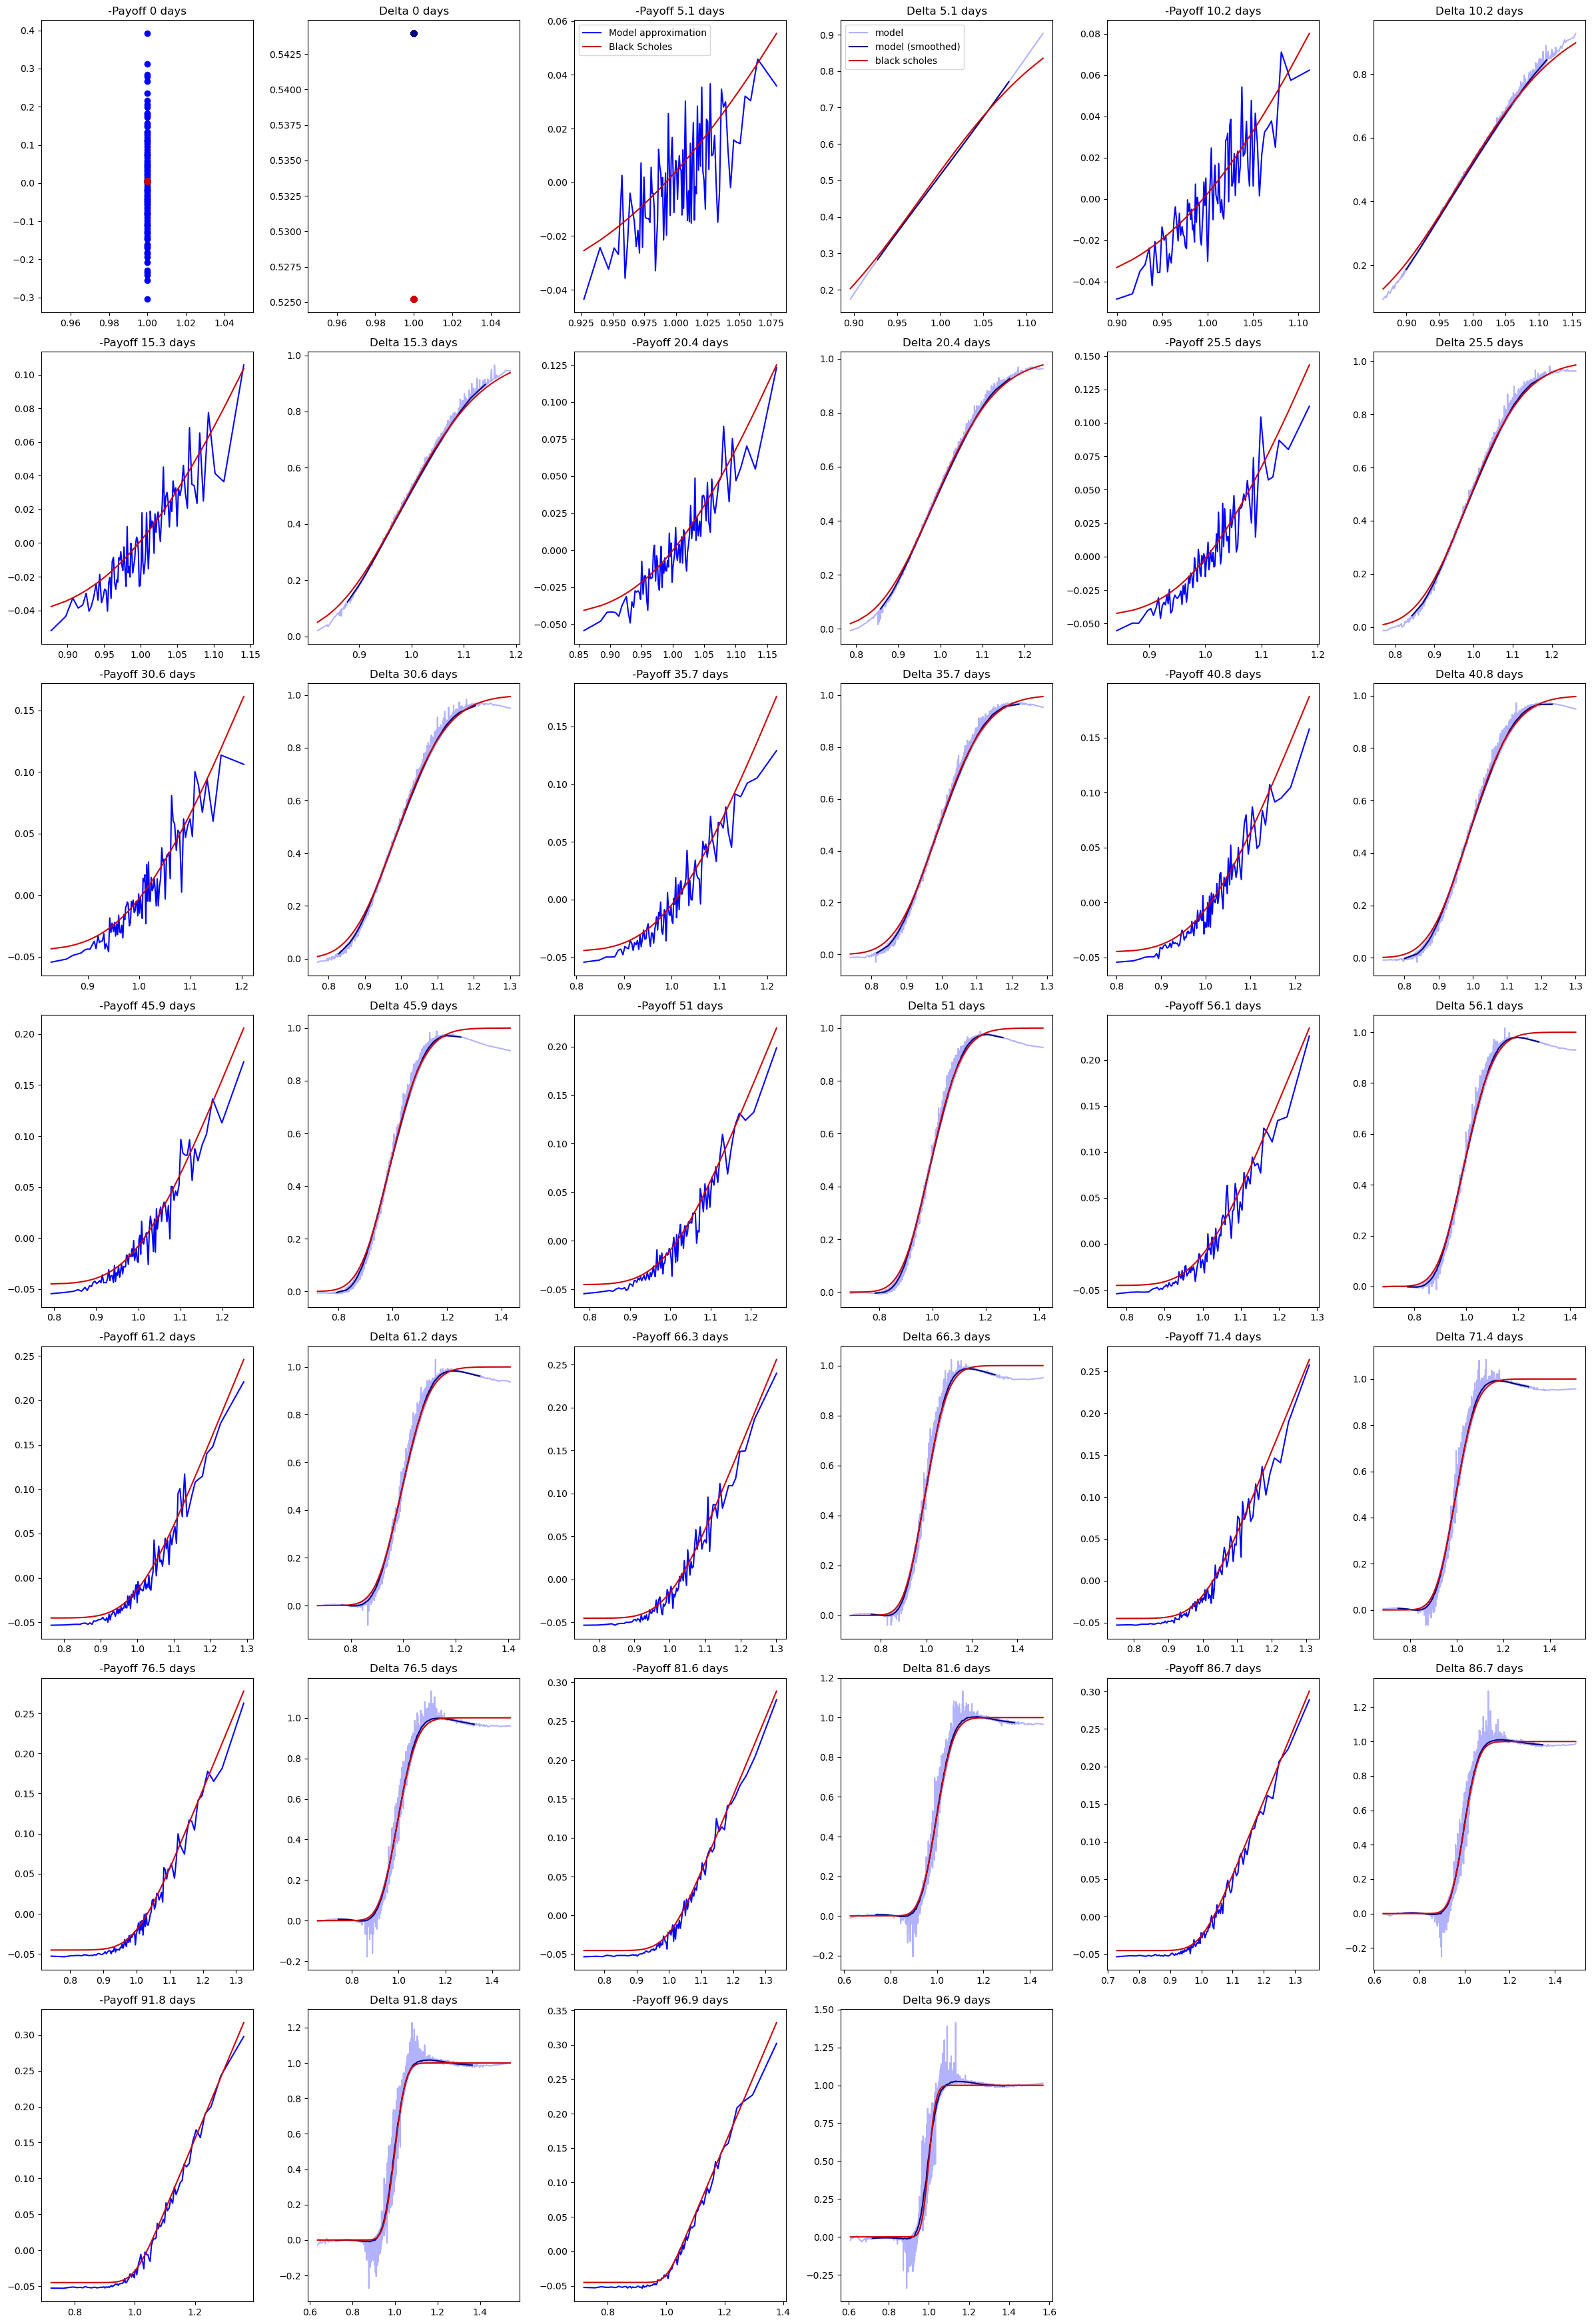

In [3]:
import deephedging.plot_bs_hedge as plot_bs_hedge
plot_bs_hedge.plot_blackscholes( world, gym, config )

## Stochastic Vol
### Trading with two assets

Deep Hedging AI says hello  ... 

## Deep Hedging in a simple Stochastic Volatility World

Gym with 1004 trainable weights compiled and initialized. Took 2s
Network feature information:
 Features used by the agent:        delta, price and time_left
 Features available to the agent:   action, call_delta, call_price, call_vega, cost, cost_v, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by the utility:      -
 Features available to the utility: call_delta, call_price, call_vega, cost, cost_v, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/9c790d18dcdcb23246560f0741db20ed.pck'
Cache successfully loaded. Current epoch: 799
Nothing to do: cached model loaded from /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/9c790d18dcdcb23246560f0741db20ed.pck was trained for 800 epochs; you have asked to train for 800 epochs. Raise number of epochs or turn off caching to re-start training.

Plotting results for the trained model.


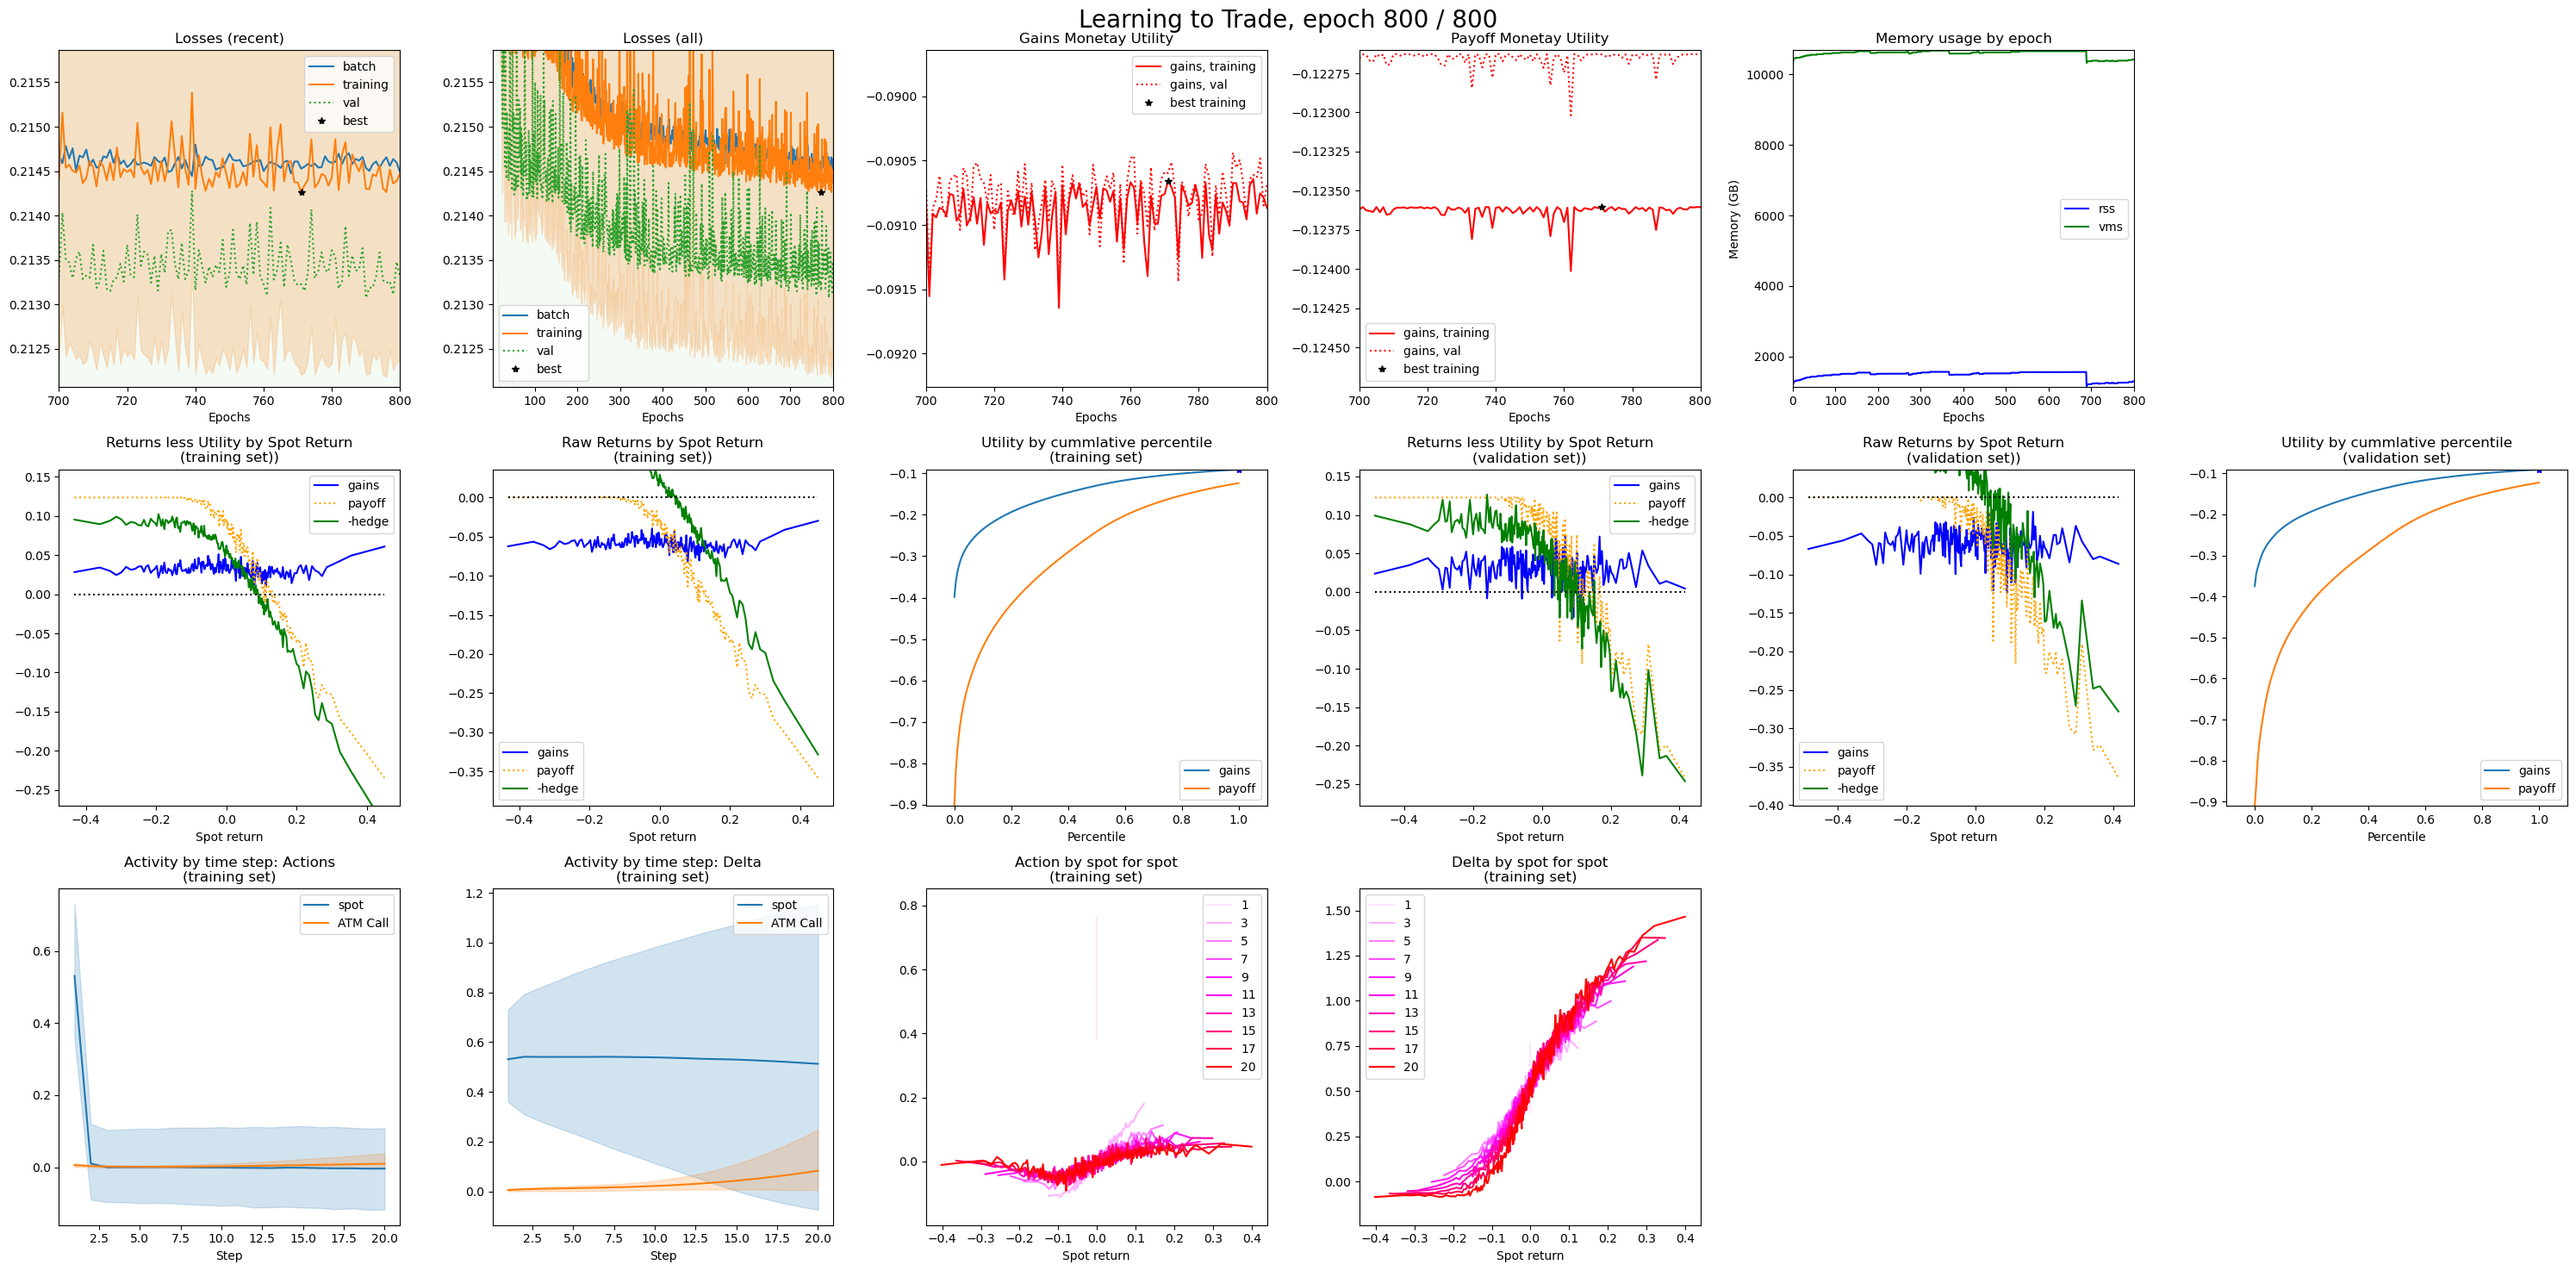

Training 800/800 epochs; 1004 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 1.03909 (0.0148514), training 0.214473 (0.00210176), best 0.214261 (0.0148514), batch 0.214491, val 0.213315 (0.00665403). Best epoch 770; last cached 799. | memory used: rss 1298.19M, vms 10426.5M | time elapsed 1:56:34; time per epoch 8s; estimated time remaining 1:56:34                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 770
 State of training until epoch 799 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/9c790d18dcdcb23246560f0741db20ed.pck

Training terminated. Total time taken 5s
Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions'])
Config usage report
config.gym.agent.network['activation'] = softplus # Network activation function; default: relu
config.gym.agent.network['depth'] = 3 # Network depth; default: 3
conf

In [4]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import tensorflow as tf

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 1.
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 800
config.trainer.caching.mode = "on"
config.trainer.train.run_eagerly = None
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a simple Stochastic Volatility World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
tf.debugging.enable_check_numerics()
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()